## Import Libraries


In [1]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedGroupKFold
import random
from tensorflow.keras import layers




## Looking at sample MRI images

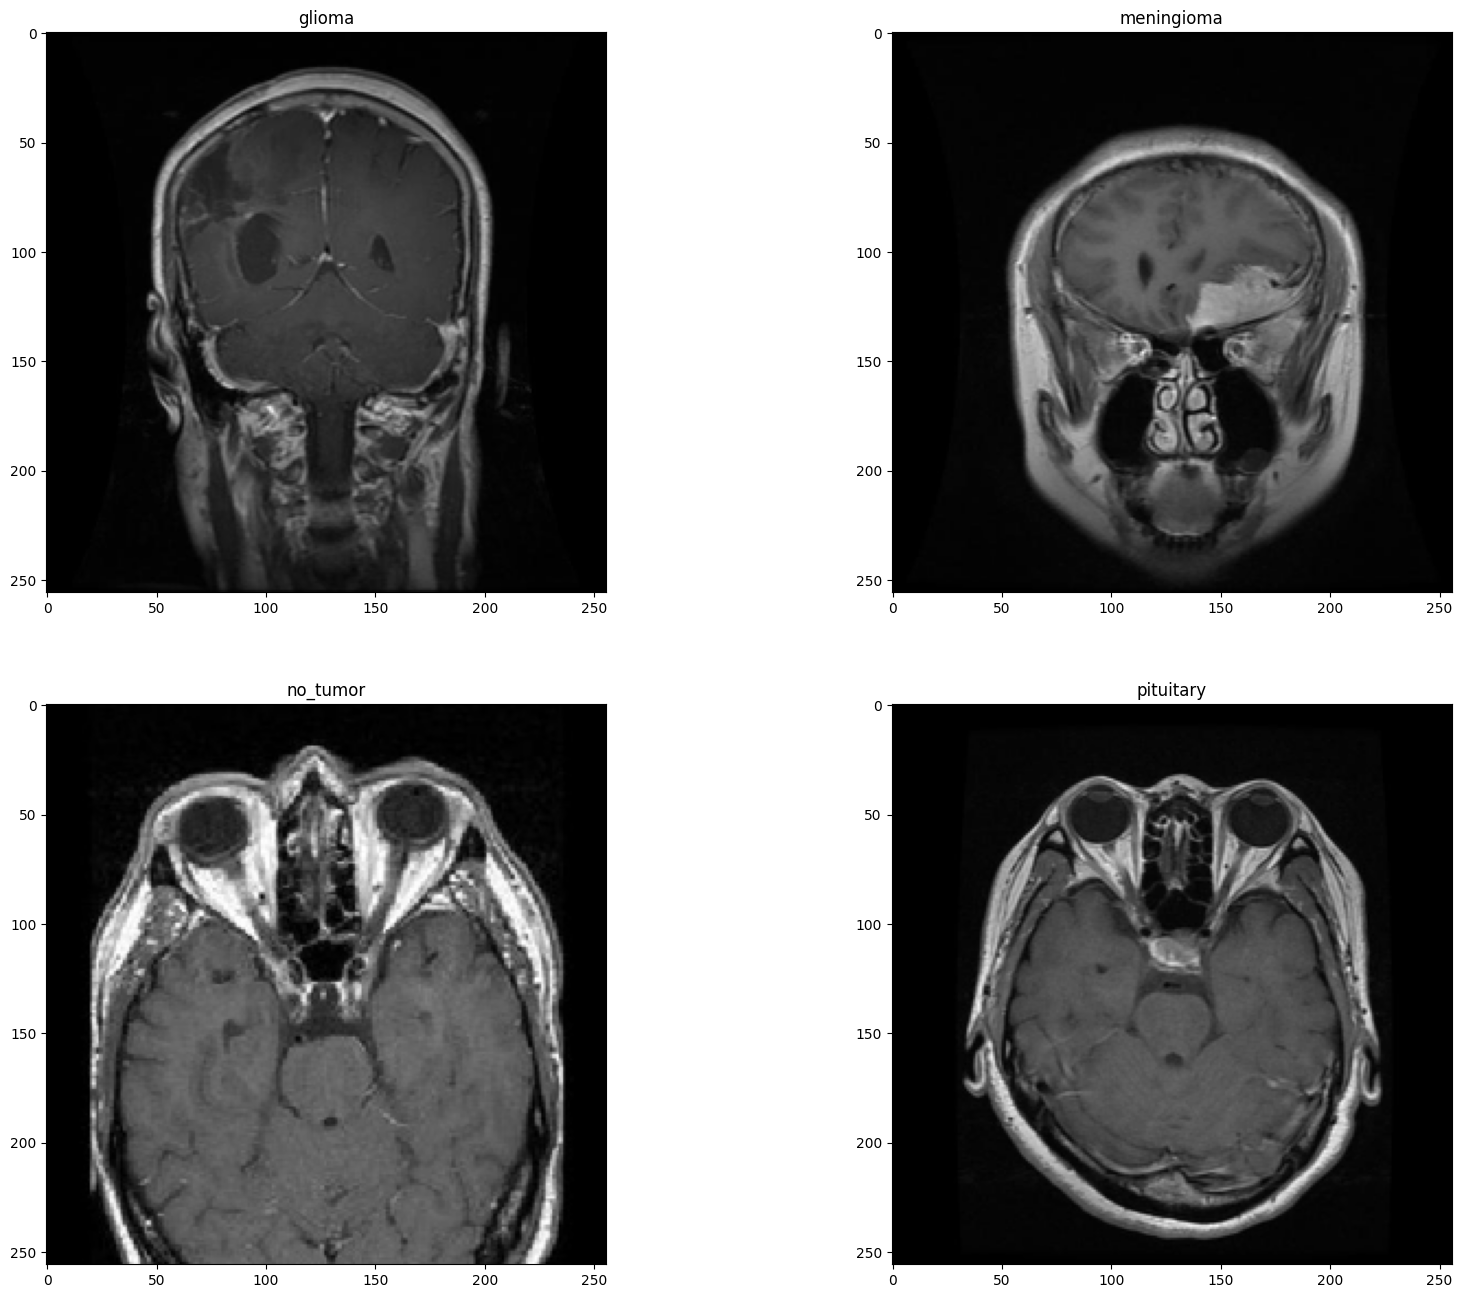

In [2]:
data_dir = (r'C:\Users\ME320\Documents\archive\Training') #Input the Training directory
categories = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
plt.figure(figsize=(20, 16))

images_path = [r'/glioma/Tr-gl_0010.jpg', r'/meningioma/Tr-meTr_0000.jpg', r'/notumor/Tr-noTr_0000.jpg', r'/pituitary/Tr-piTr_0000.jpg'] # 4 pics from each tumor heading

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (256, 256))
    plt.imshow(img)
    plt.title(categories[i])



## Cropping images to make them all the same size

In [4]:
def crop_img(img):
    """
	Finds the exterior points on the image and crops to that limit
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3),0)
    
    #Threshold the image + erode and increase size for better image
    
    thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations =2)
    
    #Find the biggest contour(curve that is a whole) and present that as the image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    #Finding the exterior points
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBottom = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img



    

In [5]:
img = cv2.imread(r'C:\Users\ME320\Documents\archive\Training\meningioma\Tr-meTr_0000.jpg') #Looking at a sample image
img = cv2.resize(
            img,
            dsize = (224,224),
            interpolation = cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3,3),0)
    
#Threshold the image + erode and increase size for better image
    
thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations = 2)
thresh = cv2.dilate(thresh, None, iterations =2)
    
#Find the biggest contour(curve that is a whole) and present that as the image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)
    
#Finding the exterior points
    
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBottom = tuple(c[c[:, :, 1].argmax()][0])

#Inputting the contour
img_cnt = cv2.drawContours(img.copy(), [c], -1,(0,255,255),4)

# Add exterior points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255,0,0), -1)
img_pnt = cv2.circle(img_pnt, extBottom, 8, (255,255,0), -1)

#Crop it
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()



Text(0.5, 1.0, 'Enlarged Image')

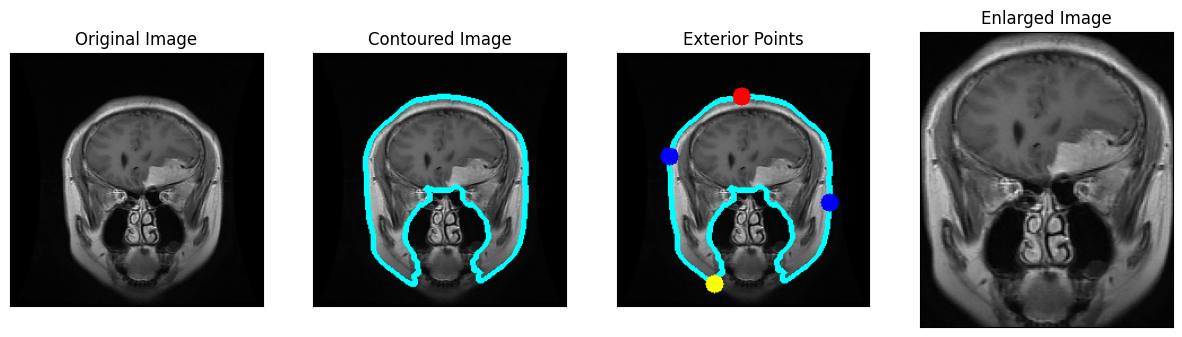

In [6]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Contoured Image')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Exterior Points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Enlarged Image')


## Cropping all the images

In [7]:
if __name__== '__main__':
    training = r'C:\Users\ME320\Documents\archive\Training'
    testing = r'C:\Users\ME320\Documents\archive\Testing'
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)
    IMG_SIZE = 256
    
    ##Writing images for the training set
    
    for dir in training_dir:
        print(dir)
        save_path = os.path.join('brain_tumor', 'cropped', 'Training', dir)
        print(save_path)
        path = os.path.join(training, dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(os.path.join(save_path, img), new_img)
    
    ## Writing images to the testing set
    for dir in testing_dir:
        save_path = os.path.join('brain_tumor', 'cropped', 'Testing', dir)
        path = os.path.join(testing, dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(os.path.join(save_path, img), new_img)
    
        

glioma
brain_tumor\cropped\Training\glioma
meningioma
brain_tumor\cropped\Training\meningioma
notumor
brain_tumor\cropped\Training\notumor
pituitary
brain_tumor\cropped\Training\pituitary


In [8]:
labels = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

x_train = [] #Image training
y_train = [] #Label training
x_test = [] #Image testing
y_test = [] #Label testing

image_size = 200

for label in labels:
    trainPath = os.path.join('brain_tumor/cropped/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath,file), 0) #Gray Images
        image = cv2.bilateralFilter(image ,2,50,50)   #Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)    #Colored Image
        image = cv2.resize(image , (image_size, image_size))    #Resize the image to 150*150
        x_train.append(image)
        y_train.append(labels.index(label))
        
    trainPath = os.path.join('brain_tumor/cropped/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath,file), 0) #Gray Images
        image = cv2.bilateralFilter(image ,2,50,50)   #Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)    #Colored Image
        image = cv2.resize(image , (image_size, image_size))    #Resize the image to 150*150
        x_test.append(image)
        y_test.append(labels.index(label))
        


100%|██████████| 1457/1457 [00:02<00:00, 491.10it/s]


In [9]:
x_train = np.array(x_train) / 255.0  #Creates an image array for normalization
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

(5712, 200, 200, 3)
(5712, 200, 200, 3)


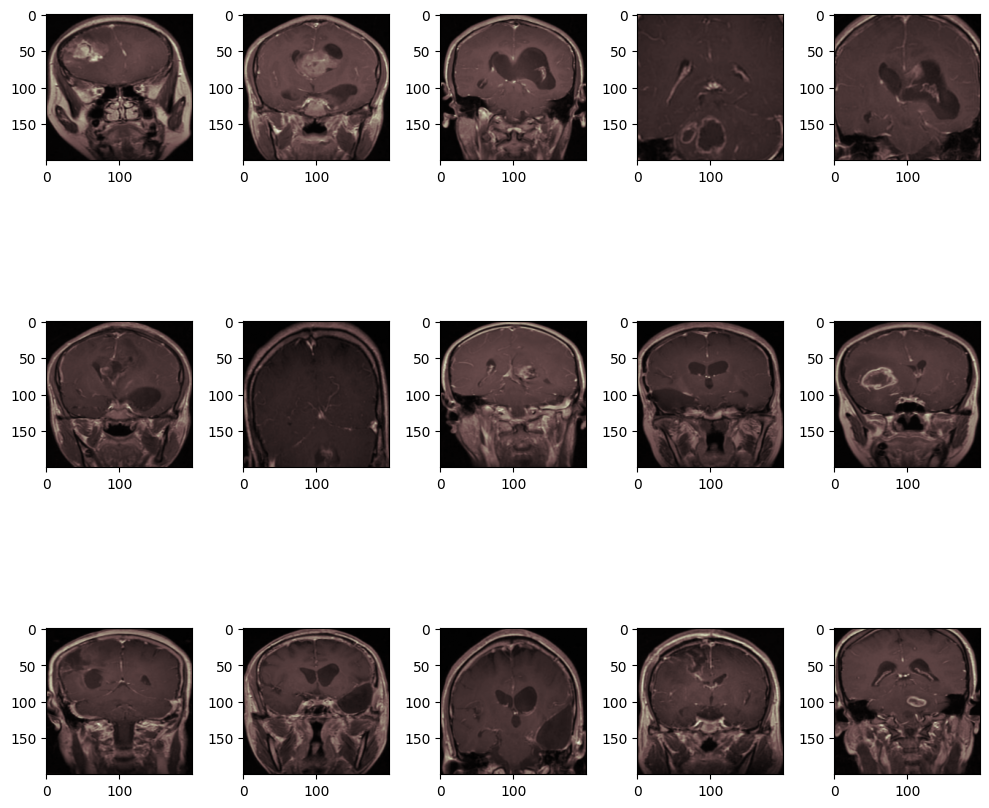

In [10]:
images = [x_train[i] for i in range(15)]
fig , axes = plt.subplots(3,5, figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(images,axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

## Setting up the model

In [11]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_val.shape)

(1143, 200, 200, 3)


## Flipping the images (demo)
 - for proper augmentation, changing the image parameters
- Below is the framework of how it would work

In [12]:
demo_datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)


if not os.path.exists('preview_2'):
    os.mkdir('preview_2')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview_2', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 


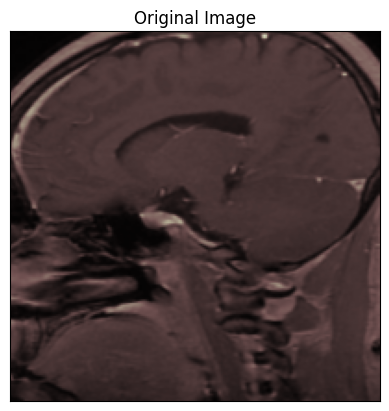

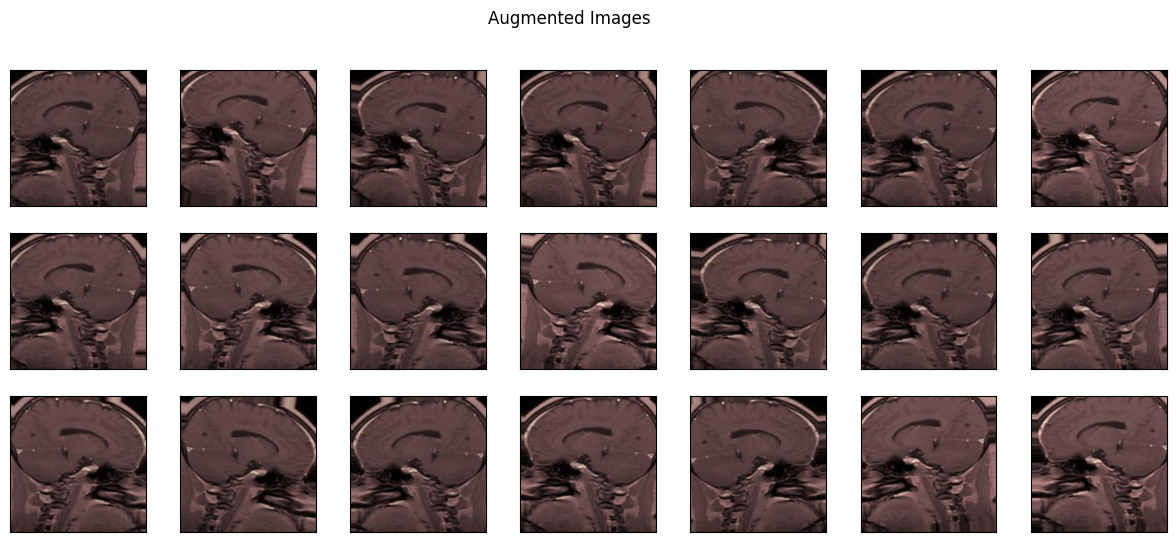

In [13]:
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i=1
for img in os.listdir('preview_2/'):
    img = cv2.imread('preview_2/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])  
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

## Actual Flipping of the images
 - increased the parameters of change to ensure maximum accuracy

In [14]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)
os.mkdir('preview_3')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview_3', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

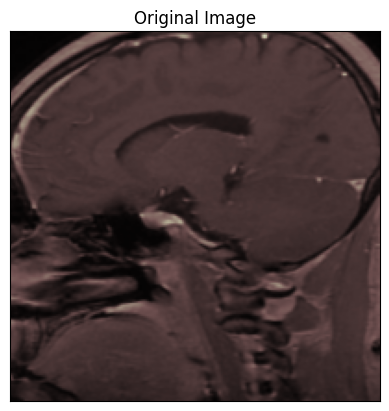

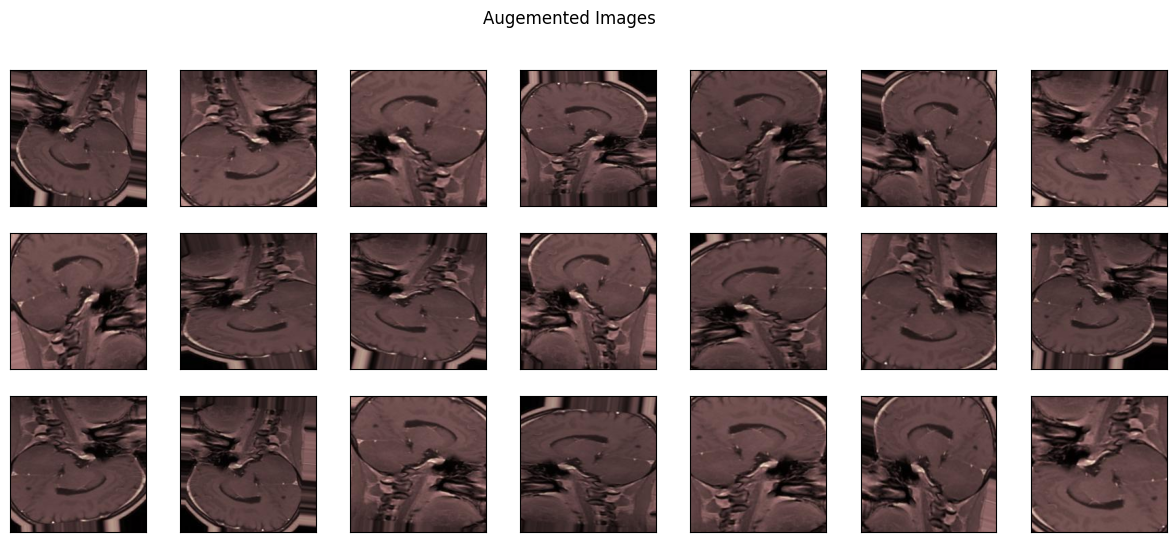

In [15]:
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_3/'):
    img = cv2.imread('preview_3/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [16]:
datagen.fit(x_train)

In [17]:
from tensorflow.keras.applications.resnet import ResNet50
IMG_SIZE = (200,200)
conv_base = ResNet50(
    include_top = False,
    input_shape = IMG_SIZE + (3,),
    weights = 'imagenet'
)

for layer in conv_base.layers:
    layer.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step


In [18]:
model = conv_base.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= conv_base.input, outputs= model)

## Model Compilation

In [19]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer= adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 206, 206,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 100, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 100, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 100, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 102, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 50, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 50, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 50, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 50, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 50, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 50, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 50, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 50, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 50, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 50, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
callbacks = [ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2,verbose=1, mode='min', min_lr=0.0000000)]

In [22]:
train_len  = len(x_train)
val_len = len(x_val)
print("--------Training Data Length--------")
print(train_len)

print("--------Validation Data Length--------")
print(val_len)

--------Training Data Length--------
4569
--------Validation Data Length--------
1143


In [23]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),validation_data = (x_val,y_val),epochs = 5,callbacks = callbacks) #This will take a LONG TIME, depending on the number of epochs


Epoch 1/5


c:\USERS\ME320\MINICONDA3\ENVS\MYENVIRONMENT\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7158 - loss: 0.6817
Epoch 1: val_loss improved from inf to 1.65663, saving model to .mdl_wts.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 780s 10s/step - accuracy: 0.7175 - loss: 0.6779 - val_accuracy: 0.2633 - val_loss: 1.6566 - learning_rate: 1.0000e-04
Epoch 2/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9451 - loss: 0.1562
Epoch 2: val_loss did not improve from 1.65663
72/72 ━━━━━━━━━━━━━━━━━━━━ 725s 10s/step - accuracy: 0.9452 - loss: 0.1561 - val_accuracy: 0.2336 - val_loss: 3.7021 - learning_rate: 1.0000e-04
Epoch 3/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9582 - loss: 0.1188
Epoch 3: val_loss did not improve from 1.65663

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
72/72 ━━━━━━━━━━━━━━━━━━━━ 726s 10s/step - accuracy: 0.9582 - loss: 0.1187 - val_accuracy: 0.2283 - val_loss: 1.8365 - learning_rate: 1.0000e-04
Epoch 4/5
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9770 - loss: 

## Plotting the Loss curves

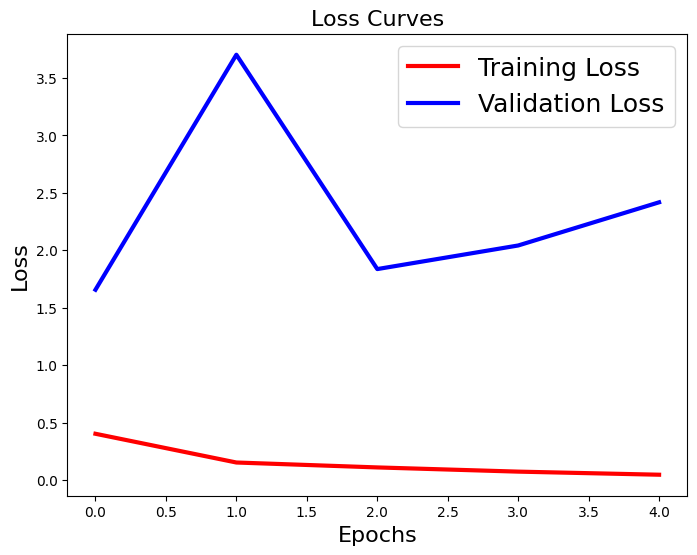

In [39]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth = 3.0)
plt.plot(history.history['val_loss'],'b', linewidth = 3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize= 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss Curves', fontsize = 16)
plt.show()

## Plotting the Accuracy curve

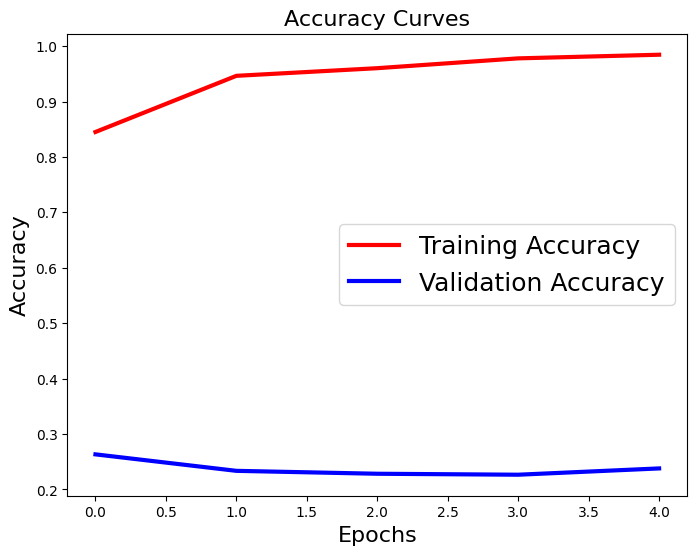

In [40]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth = 3.0)
plt.plot(history.history['val_accuracy'],'b', linewidth = 3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize= 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves', fontsize = 16)
plt.show()

In [41]:
from tensorflow.keras.models import load_model

model = load_model('.mdl_wts.keras')
model.save(r'C:\Users\ME320\Documents\archive\BIO\Model Brain\model.keras')  # Save in the native Keras format

model = load_model(r'C:\Users\ME320\Documents\archive\BIO\Model Brain\model.keras')  # Load the model

In [35]:
import seaborn as sns
predicted_classes = np.argmax(model.predict(x_test), axis =1)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes,target_names=['glioma','meningioma','no_tumor','pituitary']))


179/179 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00      1321
  meningioma       0.21      0.02      0.03      1339
    no_tumor       0.00      0.00      0.00      1595
   pituitary       0.26      0.99      0.41      1457

    accuracy                           0.26      5712
   macro avg       0.12      0.25      0.11      5712
weighted avg       0.12      0.26      0.11      5712



c:\USERS\ME320\MINICONDA3\ENVS\MYENVIRONMENT\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\USERS\ME320\MINICONDA3\ENVS\MYENVIRONMENT\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\USERS\ME320\MINICONDA3\ENVS\MYENVIRONMENT\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [42]:
import itertools
pred_Y = model.predict(x_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

668/714 ━━━━━━━━━━━━━━━━━━━━ 14s 319ms/step

## Sample Model prediction
 - starting small to check the validity of the model

179/179 ━━━━━━━━━━━━━━━━━━━━ 170s 949ms/step


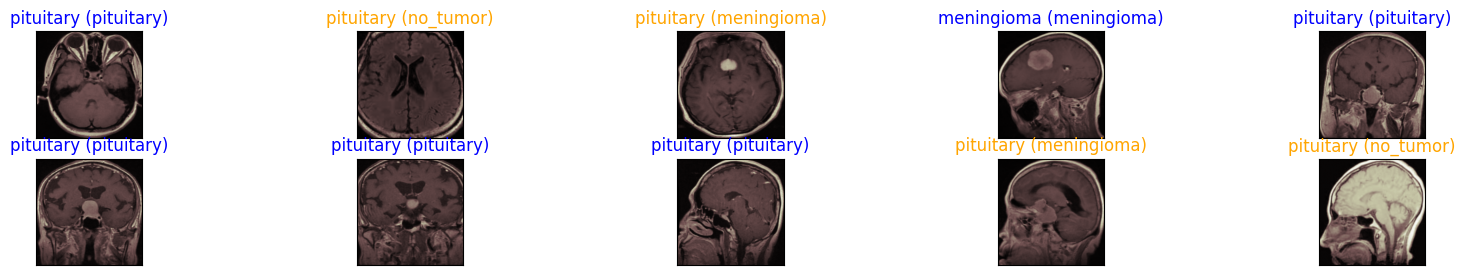

In [37]:
y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
    ax = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

## More images tend to increase error
- Can be deviated with INCREASED EPOCHS
- orange dictates a mismatch


179/179 ━━━━━━━━━━━━━━━━━━━━ 170s 948ms/step


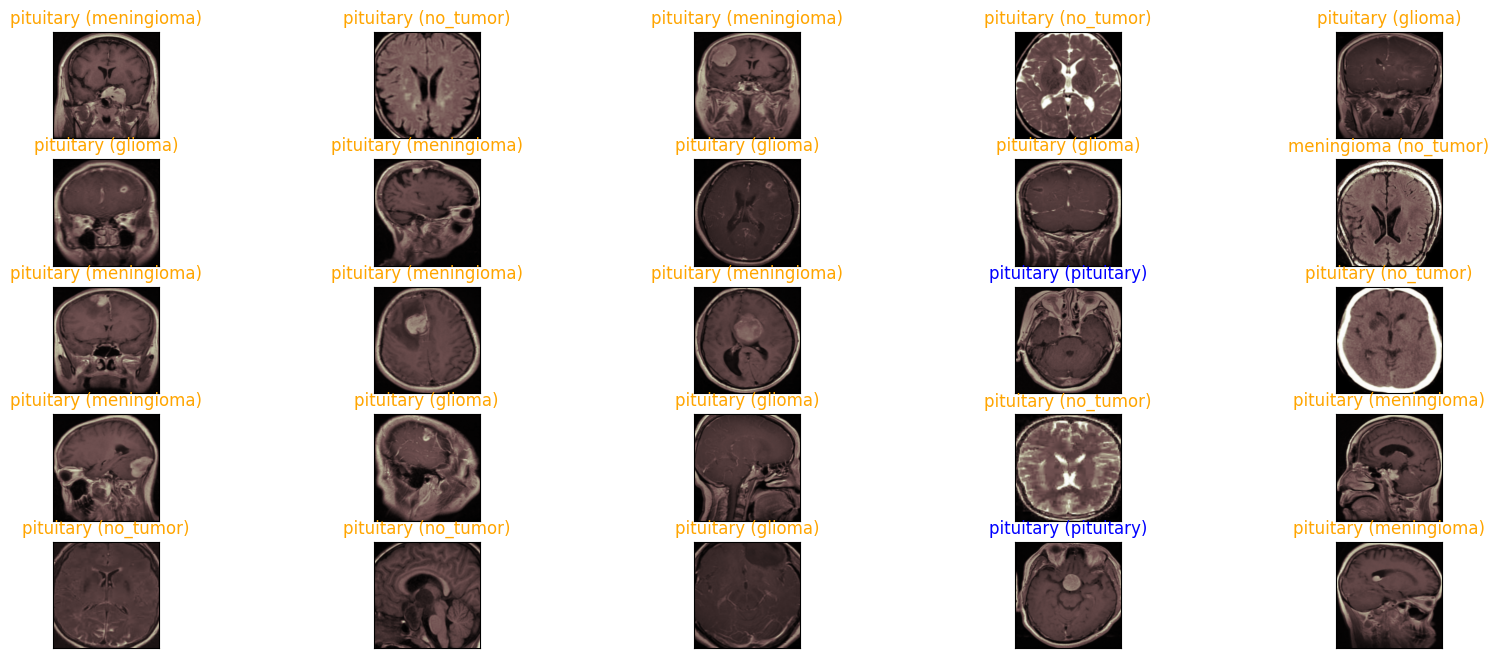

In [38]:
y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))